In [52]:
%pip install keras_self_attention
%pip install keras-tuner
%pip install pygam
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU, Dropout
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import numpy as np
import matplotlib
import os

In [54]:
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)

In [55]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import errno
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.summary import create_file_writer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kerastuner as kt
from kerastuner import HyperModel
import numpy as np
import itertools
import multiprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU, Dropout
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import numpy as np
import matplotlib
import os
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [56]:
def get_features_model(model_name, combined_models):
    for ids, models in combined_models:
        if models[0].name == model_name:
            return models[1]
    return None

def get_features_from_combined_models(combined_models, X_input):
    data_features = []
    for ids, models in combined_models:
        data_features.append(np.array(models[1].predict(X_input), dtype='float64'))
    return np.concatenate(tuple(data_features), axis=1)


In [57]:
def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")


def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

# data extraction
def getData(is500=True, shuffle=False, ise2e=False, include_secondary=False, validation_split=None, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Train_Data" if ise2e else "Fold_10_Train_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Test_Data" if ise2e else "Fold_10_Test_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    X_validation = Y_validation = None
    if validation_split is not None:
        # sklearn split shuffles anyway
        X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_split)

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eData(is500=True, shuffle=False, include_secondary=False, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Data_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Secondary_Data_1136.h5', 'r') if include_secondary else h5.File(
        f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


In [58]:
def reverse_one_hot(Y_input):
    return np.apply_along_axis(np.argmax, 1, Y_input)

def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()


def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m


def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_and_fit_model(model_func,
                          model_name,
                          input_shape,
                          X_train,
                          Y_train,
                          save_every_epoch=True,
                          save_final=False,
                          **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_every_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m


def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


def get_combined_features_from_models(
    
        to_combine,
        X_train, Y_train,
        X_test, Y_test,
        reverse_one_hot=False,
        normalize_X_func=None):
    
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    models_have_different_inputs = isinstance(Y_train,list)

    if reverse_one_hot:
        if models_have_different_inputs:
            Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1
            Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1
        else:
            Y_train_new = [ np.apply_along_axis(np.argmax, 1, y_train) + 1 for y_train in Y_train ]  
            Y_test_new = [ np.apply_along_axis(np.argmax, 1, y_test) + 1 for y_test in Y_test ]              
    else:
        if models_have_different_inputs:
            Y_train_new = Y_train.copy()
            Y_test_new = Y_test.copy()
        else:
            Y_train_new = [ y_train.copy() for y_train in Y_train ] 
            Y_test_new = [ y_test.copy() for y_test in Y_train ] 
            

    extraction_counter =0
    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter]), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter]), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter])), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter])), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here
        extraction_counter += 1

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)

    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)

    return models, data_train, data_test, XY_dict

class CNNHyperModel(HyperModel):
    def __init__(self, model_name, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_name = model_name

    def build(self, hp):
        inputs = tf.keras.Input(shape=self.input_shape)
        x = inputs

        for idx, i in enumerate(range(hp.Int('conv128_blocks_with_normalizations', 1, 6, default=4))):
            x = Conv1D(128, 3, padding='same', name=f"conv1D_128_{idx}")(x)
            if hp.Boolean(f'conv128_has_leaky_relu_{idx}', default=True):
                x = LeakyReLU()(x)
            if hp.Boolean(f'conv128_has_max_pooling_{idx}', default=True):
                x = MaxPooling1D()(x)
            if hp.Boolean(f'conv128_has_batchnorm_{idx}', default=True):
                x = BatchNormalization()(x)
            if hp.Boolean(f'conv128_has_gaussiannoise_{idx}', default=True):
                x = GaussianNoise(hp.Float(f'conv128_gaussiannoise_{idx}',
                                       min_value=1e-5,
                                       max_value=1e1,
                                       sampling='LOG',
                                       default=0.05
                                       ))(x)
        for idx, i in enumerate(range(hp.Int('conv256_blocks_with_normalizations', 1, 4, default=2))):
            x = Conv1D(256, 3, padding='same', name=f"conv1D_256_{idx}")(x)
            if hp.Boolean(f'conv256_has_leaky_relu_{idx}', default=True):
                x = LeakyReLU()(x)
            if hp.Boolean(f'conv256_has_max_pooling_{idx}', default=True):
                x = MaxPooling1D()(x)
            if hp.Boolean(f'conv256_has_batchnorm_{idx}', default=True):
                x = BatchNormalization()(x)
            if hp.Boolean(f'conv256_has_gaussiannoise_{idx}', default=True):
                x = GaussianNoise(hp.Float(f'conv256_gaussiannoise_{idx}',
                                       min_value=1e-5,
                                       max_value=1e1,
                                       sampling='LOG',
                                       default=0.05
                                       ))(x)
        x = Flatten(name="last_flatten")(x)
        for idx, i in enumerate(range(hp.Int('final_dense', 1, 5, default=2))):
            x = Dense(units=hp.Choice(f'final_dense_num_nodes_{idx}', values=[16, 32, 64, 128], default=128),
                  activation=hp.Choice(f'final_dense_kernel_activation_{idx}',
                                       values=['exponential', 'gelu', 'elu', 'relu', 'tanh'], default='relu'),
                  kernel_initializer='RandomNormal',
                  bias_initializer='zeros',
                  name=f"final_dense_{idx}")(x)
            if hp.Boolean(f'final_dense_has_dropout_{idx}', default=True):
                x = Dropout(hp.Float(f'final_dense_dropout_{idx}',
                                 min_value=0.05,
                                 max_value=0.75,
                                 step=0.05,
                                 default=0.2
                                 ), name=f"final_dense_dropout_{idx}")(x)
        outputs = Dense(self.num_classes, activation='softmax', name="last_softmax")(x)
        model = tf.keras.Model(inputs, outputs, name=self.model_name)
        #  m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        if hp.Boolean('optimize_adam', default=True):
            model.compile(
                optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        else:
            model.compile(
                optimizer=hp.Choice('final_optimizer',
                                    values=['adam', 'SGD', 'RMSprop', 'Adadelta', 'Nadam', 'Adamax', 'Adagrad'],
                                    default='adam'),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        return model
    

def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer
    
            old_weights, old_biases = model.layers[ix].get_weights()
    
            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])            
    return model

def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32),(0,)) )

   
def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def misclass_perc_to_weight(input_confusion, add_base=True, func=None):
    perc_misclassified = 1.0 - np.array([ input_confusion[x,x] for x in np.arange(input_confusion.shape[0]).tolist() ])/input_confusion.sum(axis=1)
    
    base_val = min(perc_misclassified[perc_misclassified>0.0])
    if add_base:        
        perc_misclassified = perc_misclassified + base_val
    
    perc_misclassified = [ x/base_val for x in perc_misclassified]
    
    return dict([ (idx, func(perc_val)) if func is not None else (idx, perc_val) for idx, perc_val in enumerate(perc_misclassified) ])


def sparse_setdiff(a1, a2):
    a1a = a1.reshape(a1.shape[0], -1)
    a2a = a2.reshape(a2.shape[0], -1)
    spa2a = [np.where(x)[0].tolist() for x in a2a]
    spa1a = [np.where(x)[0].tolist() for x in a1a]
    idxs_to_keep = []
    for idx, sample in enumerate(spa1a):
        try:
            spa2a.index(sample)
        except ValueError:
            # not in list
            idxs_to_keep.append(idx)
    return a1[idxs_to_keep], idxs_to_keep


In [59]:
class DNNFeatureMergeModel(HyperModel):
    
    def __init__(self, model_name, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_name = model_name

    def build(self, hp):
        inputs = tf.keras.Input(shape=self.input_shape)
        x = inputs
        for idx, i in enumerate(range(hp.Int('dense_blocks_with_normalizations', 1, 10, default=1))):
            if hp.Boolean(f'has_batchnormalization_{idx}', default=True):
                x = BatchNormalization()(x)
            x = Dense(units= hp.Choice(f'dense_block_nunits_{idx}', values=[16,32,64,128,256,512],default=128), 
                      activation=hp.Choice(f'dense_activation_{idx}',
                                       values=['selu', 'gelu', 'elu', 'relu', 'tanh', 'linear'], default='relu'),
                  kernel_initializer=hp.Choice(f'dense_kernel_init_{idx}',
                                       values=['HeNormal', 'HeUniform','VarianceScaling', 'LecunNormal','LecunUniform', 'GlorotUniform', 'GlorotNormal', 'RandomNormal', 'Ones', 'Orthogonal'], default='RandomNormal'),
                  bias_initializer='zeros',
                  name=f'dense_{idx}')(x)
            if hp.Boolean(f'has_leakyrelu_{idx}', default=True):
                x = LeakyReLU()(x)
            if hp.Boolean(f'has_dropout_{idx}', default=True):
                x = Dropout(hp.Float(f'dense_dropout_value_{idx}',
                                 min_value=0.0,
                                 max_value=0.99,
                                 step=0.025,
                                 default=0.6
                                 ), name=f"dense_dropout_{idx}")(x)
        outputs = Dense(self.num_classes, activation='softmax', name="last_softmax")(x)
        model = tf.keras.Model(inputs, outputs, name=self.model_name)
        if hp.Boolean('optimize_adam', default=True):
            model.compile(
                optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-7, 0.5e-1, sampling='log')),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        else:
            model.compile(
                optimizer=hp.Choice('final_optimizer',
                                    values=['adam', 'SGD', 'RMSprop', 'Adadelta', 'Nadam', 'Adamax', 'Adagrad'],
                                    default='adam'),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        return model
    

class BatchSizeTuner(kt.tuners.Hyperband):
   def run_trial(self, trial, *args, **kwargs):
#     # You can add additional HyperParameters for preprocessing and custom training loops via overriding `run_trial`
     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 16, 256, step=32)
     super(BatchSizeTuner, self).run_trial(trial, *args, **kwargs)


In [60]:
# 'new' data 
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData(is500=False,
                                                                                                    include_secondary=False,
                                                                                                    isColab=True)
X_train_1000e_w2nd, Y_train_1000e_w2nd, X_test_1000e_w2nd, Y_test_1000e_w2nd, X_val_1000e_w2nd, Y_val_1000e_w2nd = getE2eData(is500=False, include_secondary=True, isColab=True)
X_train_1000e_j2nd, Y_train_1000e_j2nd, X_test_1000e_j2nd, Y_test_1000e_j2nd, X_val_1000e_j2nd, Y_val_1000e_j2nd = getE2eDataJustSecondary(isColab=True)

In [61]:
print (X_train_1000e.shape)
print (X_train_1000e_w2nd.shape)
print (X_train_1000e_j2nd.shape)

(6858, 1000, 8)
(6858, 1136, 12)
(6858, 1000, 3)


In [62]:
    # merge into a new train:
    X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
    Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )    
    
    X_new_train_j2nd = np.concatenate( (X_train_1000e_j2nd, X_val_1000e_j2nd), axis=0 )
    Y_new_train_j2nd = np.concatenate( (Y_train_1000e_j2nd, Y_val_1000e_j2nd), axis=0 )    

    X_new_train_w2nd = np.concatenate( (X_train_1000e_w2nd, X_val_1000e_w2nd), axis=0 )
    Y_new_train_w2nd = np.concatenate( (Y_train_1000e_w2nd, Y_val_1000e_w2nd), axis=0 )    

    # CNNs no secondary
    mCNN1_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/CNN_baseline_May16_e2e1000_256.h5") # CNN on 256 1st dens
    mCNN1_1000._name = "cnn_merged_newdata_finalist_1"

    mCNN2_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/CNN_baseline_May16_e2e.h5")   # CNN on 128 1st dens
    mCNN2_1000._name = "cnn_merged_newdata_finalist_2"
    
    mCNN_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/cnn_noTest_20210516_model_445_0.998")   # CNN on 128 1st dens
    mCNN_1000._name = "cnn_merged_newdata_colab_finalist"
    
    # CNN w/ secondary
    mCNN_1000_w2nd = load_model("./drive/MyDrive/data_papers/ncRNA/CNN_baseline_May16_e2e_secondary.h5", custom_objects=SeqWeightedAttention.get_custom_objects())
    mCNN_1000_w2nd._name = "cnn_merged_newdata_w_secondary_finalist"

    # CNN secondary only
    mCNN_1000_j2nd = load_model("./drive/MyDrive/data_papers/ncRNA/cnn_j2nd_noTest_20210516_model_488_0.990", custom_objects=SeqWeightedAttention.get_custom_objects())
    mCNN_1000_j2nd._name = "cnn_merged_newdata_j_secondary_finalist"
    
    mCNN1_1000.evaluate(X_test_1000e, Y_test_1000e)  # 96.15% 
    mCNN2_1000.evaluate(X_test_1000e, Y_test_1000e)  # 95.80 %  
    mCNN_1000.evaluate(X_test_1000e, Y_test_1000e)  # 95.57% 
    mCNN_1000_w2nd.evaluate(X_test_1000e_w2nd, Y_test_1000e_w2nd)  # 94.64 %
    mCNN_1000_j2nd.evaluate(X_test_1000e_j2nd, Y_test_1000e_j2nd)  # 72.96 %


27/27 [==============================] - 0s 5ms/step - loss: 1.7761 - accuracy: 0.7296


[1.7760889530181885, 0.7296037077903748]

In [15]:
 # tf.keras.utils.plot_model(mCNN_1000_j2nd, show_shapes=True)  ## , to_file="C:/temp/test.png")

In [63]:
    to_combine_last_layers_no2nd_j2nd = [
        (mCNN_1000, "dense_2", None),
        (mCNN1_1000, "dense_26", None),
        (mCNN2_1000, "dense_14", None),
        (mCNN_1000_j2nd,"dense_5", None)
    ]

    combined_models_no2nd_j2nd, data_train_ll_no2nd_j2nd, data_test_ll_no2nd_j2nd, data_access_ll_no2nd_j2nd = get_combined_features_from_models(
        to_combine_last_layers_no2nd_j2nd,
        [ X_new_train, X_new_train, X_new_train, X_new_train_j2nd],
        [ Y_new_train, Y_new_train, Y_new_train, Y_new_train_j2nd], 
        [ X_test_1000e, X_test_1000e, X_test_1000e, X_test_1000e_j2nd],
        [ Y_test_1000e, Y_test_1000e, Y_test_1000e, Y_test_1000e_j2nd],
        reverse_one_hot=False)


In [64]:
xTrainToR = data_train_ll_no2nd_j2nd[0]
yTrainToR = data_train_ll_no2nd_j2nd[1][0]
yTrainToR.shape

(7715, 13)

In [65]:
%%R 
install.packages(c("foreach","mgcv"))

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/foreach_1.5.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 87352 bytes (85 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [74]:
%R -i xTrainToR
%R -i yTrainToR


In [75]:
%%R
require(data.table)
require(foreach)
yTrainToR = apply(yTrainToR,1,which.max)


In [76]:
%%R
rdata = data.table(cbind(yTrainToR,xTrainToR))
# show(head(rdata[1:4,1:10],4))
# show(head(yTrainToR,4))
# show(head(xTrainToR[,1:4],4))
# rdata=data.table(rdata)
# colnames(rdata)



In [79]:
%%R
foreach(outValue = sort(unique(rdata$yTrainToR)), .combine = rbind) %do%
{
    rdata[yTrainToR==outValue]
}


          [,1]
result.1   627
result.2   616
result.3   630
result.4   619
result.5   625
result.6   626
result.7   607
result.8   594
result.9   624
result.10  623
result.11  400
result.12  581
result.13  543


In [72]:
%%R
require(foreach)
colnames(rdata)

rdataSubset <- foreach(outValue = unique(rdata$yTrainToR), .combine = rbind) %do%
{
    return(sample(rdata[yTrainToR==outValue],10,replace=F))
}




R[write to console]: Loading required package: foreach

R[write to console]: Error in { : 
  Column 1 ['V37'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names.




Error in { : 
  Column 1 ['V37'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names.


RInterpreterError: ignored

In [ ]:
%%R
require(mgcv)
set.seed(6)

.

plot(x1,x2,col=y+3)

## now fit the model...
# b <- gam(list(y~s(x1)+s(x2),~s(x1)+s(x2)),family=multinom(K=2))
# plot(b,pages=1)
# gam.check(b)

# ## now a simple classification plot...
# expand.grid(x1=seq(0,1,length=40),x2=seq(0,1,length=40)) -> gr
# pp <- predict(b,newdata=gr,type="response")
# pc <- apply(pp,1,function(x) which(max(x)==x)[1])-1
# plot(gr,col=pc+4,pch=19)


Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-1.260955e-05,7.167128e-05]
(score 729.5551 & scale 1).
Hessian positive definite, eigenvalue range [0.1937807,2.149332].
Model rank =  38 / 38 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

          k'  edf k-index p-value
s(x1)   9.00 6.75    1.03    0.88
s(x2)   9.00 2.70    0.96    0.15
s.1(x1) 9.00 2.34    1.03    0.84
s.1(x2) 9.00 1.87    0.96    0.16


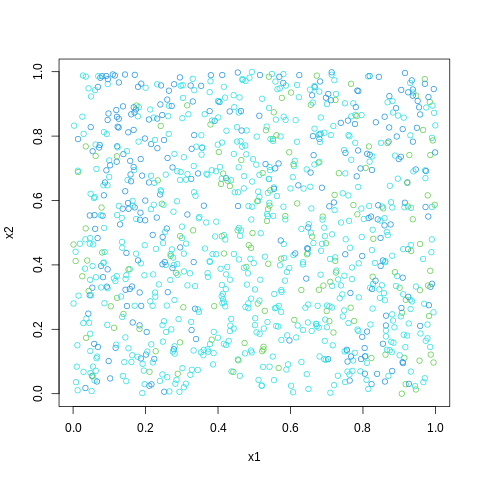

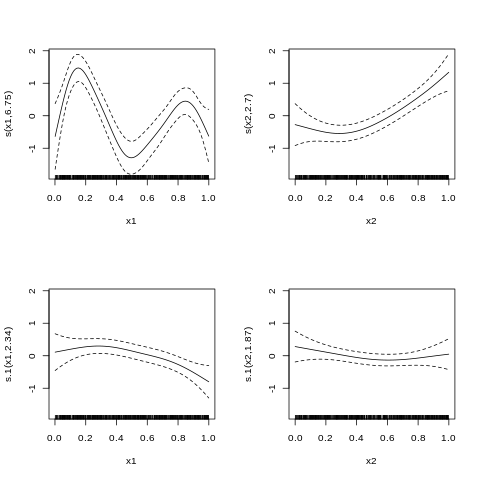

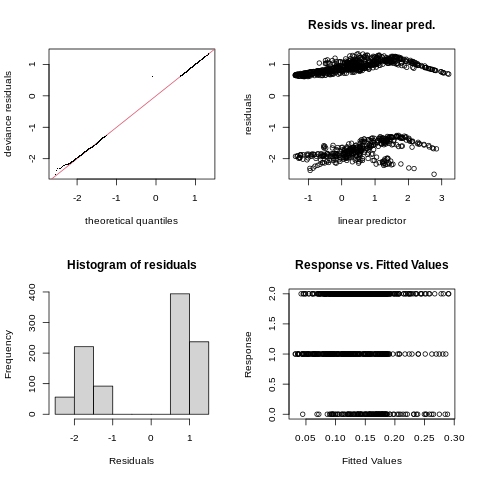

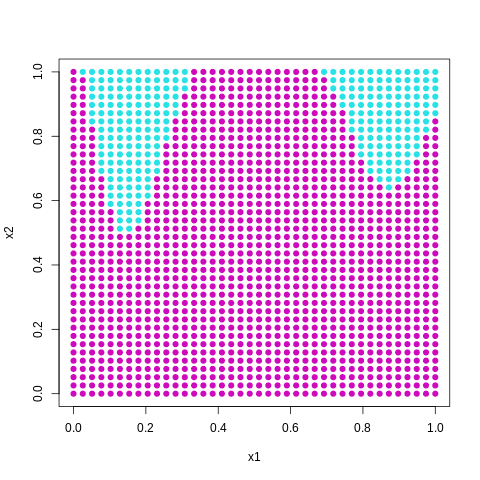

In [21]:
%%R
require(mgcv)
# data(trees)
# ct1=gam(Volume ~ s(Height)+s(Girth), family=Gamma(link=log), data=trees)
# summary(ct1)
# plot(ct1, residuals=T)
set.seed(6)
## simulate some data from a three class model
n <- 1000
f1 <- function(x) sin(3*pi*x)*exp(-x)
f2 <- function(x) x^3
f3 <- function(x) .5*exp(-x^2)-.2
f4 <- function(x) 1
x1 <- runif(n);x2 <- runif(n)
eta1 <- 2*(f1(x1) + f2(x2))-.5
eta2 <- 2*(f3(x1) + f4(x2))-1
p <- exp(cbind(0,eta1,eta2))
p <- p/rowSums(p) ## prob. of each category 
cp <- t(apply(p,1,cumsum)) ## cumulative prob.
## simulate multinomial response with these probabilities
## see also ?rmultinom
y <- apply(cp,1,function(x) min(which(x>runif(1))))-1


In [ ]:

## plot simulated data...
plot(x1,x2,col=y+3)

## now fit the model...
b <- gam(list(y~s(x1)+s(x2),~s(x1)+s(x2)),family=multinom(K=2))
plot(b,pages=1)
gam.check(b)

## now a simple classification plot...
expand.grid(x1=seq(0,1,length=40),x2=seq(0,1,length=40)) -> gr
pp <- predict(b,newdata=gr,type="response")
pc <- apply(pp,1,function(x) which(max(x)==x)[1])-1
plot(gr,col=pc+4,pch=19)